<a href="https://colab.research.google.com/github/SterlingHayden/Convex-Optimization/blob/main/IntroToCVXPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 10: Introduction to CVXPY

---

## Objectives

Students will be skilled at

1. identifying convex optimization models (using CVXPY)
2. implementing and solving convex optimization models in CVXPY, and outputting/interpreting their results

## References

1. [CVXPY Documentation](https://www.cvxpy.org/)

## Overview of CVXPY

CVXPY is a Python-based, open source modeling language for convex optimization.  CVXPY is distributed with a number of open-source solvers, and it can also be [configured](https://www.cvxpy.org/tutorial/advanced/index.html#solve-method-options) to call other solvers (e.g., including CBC for solving LPs).

## Importing CVXPY

In [ ]:
import cvxpy as cp

## Example 1: Solving a Simple Convex Optimization Problem using CVXPY

### Statement of Optimization Model

$\begin{align}
\min \  &&& e^{x + 3y - 0.1} + e^{y - 3z - 0.1} + e^{-3x + z - 0.1} \\
\textrm{s.t.}\ &&& 2x + y - 3z \leq 0\\
&&& x + y \leq 1\\
&&& x + y + z <= 2 \\
&&& x, y, z \geq 0
\end{align}$

### Implement/Solve using CVXPY

In [ ]:
x = cp.Variable(nonneg=True)
y = cp.Variable(nonneg=True)
z = cp.Variable(nonneg=True)

In [ ]:
constraints = [2*x + y - 3*z <= 0, x + y <= 1, x + y + z <= 2]

In [ ]:
obj = cp.Minimize(cp.exp(x + 3*y - 0.1) + cp.exp(y - 3*z - 0.1) + cp.exp(-3*x + z - 0.1))

In [ ]:
prob = cp.Problem(obj, constraints)
prob.solve()

1.9942498569434557

In [ ]:
print("status: ", prob.status)
print("obj val: ", prob.value)
print("optimal value of x: ", x.value)
print("optimal value of y: ", y.value)
print("optimal value of z: ", z.value)

status:  optimal
obj val:  1.9942498569434557
optimal value of x:  0.42254318626506526
optimal value of y:  0.0
optimal value of z:  0.591560477593907


## Example 2: Solving a (Convex) Quadratic Program using CVXPY

### Statement of Optimization Model

$\begin{align}
\min \  &&& 2x_1^2 - 6x_1x_2 + 12.5x_2^2 + 3x_1 - 5x_2 \\
\textrm{s.t.}\ &&& x_1 + x_2 \geq 0.5\\
&&& x_1 - 3x_2 \leq 0\\
&&& x_1, x_2 \textrm{ unrestricted}
\end{align}$

Note: We showed in Lesson 9 that this objective function is convex.  The constraints are linear (and therefore convex), so this is a convex optimization problem.


### Implement/Solve using CVXPY (1st attempt)

In [ ]:
x = cp.Variable(2) # defines variables x[0] and x[1]
obj = cp.Minimize(2*(x[0]**2) - 6*x[0]*x[1] + 12.5*(x[1]**2) + 3*x[0] - 5*x[1])

In [ ]:
constraints = [x[0] + x[1] >= 0.5, x[0] - 3*x[1] <= 0]

In [ ]:
prob = cp.Problem(obj, constraints)
#prob.solve()

The error "DCPError: Problem does not follow DCP rules" is telling us that CVXPY could not verify that the problem is a convex optimization problem.  This could be because:

*   the problem is not convex
*   the problem is convex, but CVXPY could not recognize it as convex

In the latter case, it may be possible to use built-in CVXPY functions to formulate the problem in a way that enables CVXPY to recognize it as a convex optimization problem.


### Implement/Solve using CVXPY (2nd attempt)

This section solves an optimization problem represented in matrix form.  For this kind of problem, NumPy can be used to represent constants.

In [ ]:
import numpy as np

Note that the objective can be rewritten as
\begin{align}
  &&& \frac{1}{2} x^TQx + p^Tx,
\end{align}
where
\begin{equation}Q = \left[ \begin{array}{rr} 4 & -6\\ -6 & 25\end{array} \right], \ p = \left[\begin{array}{r} 3 \\ -5 \end{array} \right], \ x = \left[\begin{array}{r} x_1 \\ x_2 \end{array} \right].\end{equation}

That is, the objective is$\ldots$
\begin{equation}
\frac{1}{2}[x_1, \ x_2] \left[ \begin{array}{rr} 4 & -6\\ -6 & 25\end{array} \right] \left[\begin{array}{r} x_1 \\ x_2 \end{array} \right] + [3, \ -5]\left[\begin{array}{r} x_1 \\ x_2 \end{array} \right]
\end{equation}

In [ ]:
# Define the matrix Q and vector p
Q = np.array([[4, -6],[-6, 25]])
p = np.array([3, -5])
print(Q)
print(p)

[[ 4 -6]
 [-6 25]]
[ 3 -5]


We can define the model using [built-in CVXPY functions](https://www.cvxpy.org/tutorial/functions/index.html).

In [ ]:
#Build CVXPY model
x = cp.Variable(2) # defines variables x[0] and x[1]
obj = cp.Minimize(0.5*cp.quad_form(x,Q) + p.T @ x) # use @ for matrix-matrix multiplication

In [ ]:
constraints = [x[0] + x[1] >= 0.5, x[0] - 3*x[1] <= 0]

In [ ]:
prob = cp.Problem(obj, constraints)
prob.solve()

-0.06097560975609739

In [ ]:
print("status: ", prob.status)
print("optimal obj val: ", prob.value)
print("optimal solution: ", x.value)

status:  optimal
optimal obj val:  -0.06097560975609739
optimal solution:  [0.18292683 0.31707317]


In [ ]:
# useful commands for debugging model
print(x.shape)
print(Q.shape)

(2,)
(2, 2)


## Example 3: A Non-Convex Quadratic Program

### Statement of Optimization Model

We now wish to solve the unconstrained optimization problem
\begin{align}
\min \  &&& \frac{1}{2} x^TQx + p^Tx
\end{align}
where
\begin{equation}Q = \left[ \begin{array}{rr} 2 & -4\\ -4 & 2\end{array} \right], \ p = \left[\begin{array}{r} 10 \\ 20 \end{array} \right], \ x = \left[\begin{array}{r} x_1 \\ x_2 \end{array} \right].\end{equation}

We showed in Lesson 9 that this objective function is not convex.

### Solve using CVXPY

In [ ]:
# Define the matrix Q and vector p
Q = np.array([[2, -4],[-4, 2]])
p = np.array([10, 20])

In [ ]:
#Build CVXPY model
x = cp.Variable(2) # defines variables x[0] and x[1]
obj = cp.Minimize(0.5*cp.quad_form(x,Q) + p.T @ x) # use @ for matrix-matrix multiplication
constraints = [x[0] + x[1] >= 0.5, x[0] - 3*x[1] <= 0]
prob = cp.Problem(obj, constraints)
prob.solve()

DCPError: ignored

# Example 4: Performing Sensitivity Analysis on a Parameter

Reconsider the model from Example 2.  Previously, the right-hand side of constraint 1 was $\color{red}{\lambda} = 0.5$:

\begin{align}
\min \  &&& 2x_1^2 - 6x_1x_2 + 12.5x_2^2 + 3x_1 - 5x_2 \\
\textrm{s.t.}\ &&& x_1 + x_2 \geq \color{red}{\lambda}\\
&&& x_1 - 3x_2 \leq 0\\
&&& x_1, x_2 \textrm{ unrestricted}
\end{align}

Suppose we wish to solve the model for each $\lambda$ in $\{-1,-0.9,-0.8,\ldots,0.8,0.9,1\}$.

### Defining a CVXPY Parameter

In [ ]:
# Define the matrix Q and vector p
Q = np.array([[4, -6],[-6, 25]])
p = np.array([3, -5])

#Build CVXPY model
x = cp.Variable(2) # defines variables x[0] and x[1]
obj = cp.Minimize(0.5*cp.quad_form(x,Q) + p.T @ x) # use @ for matrix-matrix multiplication

CVXPY problems are immutable, meaning a problem cannot be changed after it is constructed with "cp.Problem()".  To save us from having to define a new problem for each value of $\lambda$, we can define $\lambda$ as a parameter of the model.


In [ ]:
lam = cp.Parameter()
constraints = [x[0] + x[1] >= lam, x[0] - 3*x[1] <= 0]
prob = cp.Problem(obj, constraints)

In [ ]:
lam.value = 0.5
prob.solve()

-0.06097560975609739

### Solving the Model and Plotting the Results

In [ ]:
lam_vals = np.linspace(-1,1,21)
print(lam_vals)
optimal_obj_vals = []
for val in lam_vals:
  lam.value = val
  prob.solve()
  optimal_obj_vals.append(prob.value)
  #print("obj val: ", prob.value)

print(optimal_obj_vals)

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
[-1.1328124999877642, -1.1328125, -1.1328124999999998, -1.1328124999999998, -1.1287805373440414, -1.1097562623800972, -1.0751222119338892, -1.0248784053899167, -0.9590248427483834, -0.8775615240092889, -0.7804884491726332, -0.6678056182384159, -0.5395130312066384, -0.3956106880772997, -0.23609858885039958, -0.06097673352594002, 0.12975487789608087, 0.3360962454156655, 0.5580473690328078, 0.7956082487475127, 1.0487788845597763]


In [ ]:
import matplotlib.pyplot as plt

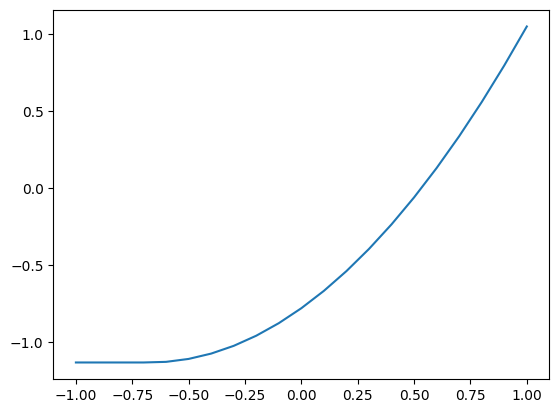

In [ ]:
plt.plot(lam_vals, optimal_obj_vals)
#plt.xlabel($\lambda$)

## Example 5: Least-Squares Regression

### Statement of Optimization Model

In this example, we formulate and solve a least-squares (linear) regression model using CVXPY.  That is, suppose we are given the following:

*	$m =$ number of data points observed (indexed by $i=1,2,\ldots,m$)
*	$n =$ number of features (indexed by $j=1,2,\ldots,n$)
*	$x_{ij}=$ value of feature $j$ in data point $i$
*	$y_i =$  response value for data point $i$

We wish to find coefficients $\beta_j$ ($j = 1,2,\ldots,n$) and $b$ to solve the problem

$$\min_{b,\beta} \sum_{i = 1}^m \left((b + \sum_{j = 1}^n\beta_jx_{ij})- y_i \right)^2$$

This problem is equivalent to

$$\min_{b,\beta} \|be + X\beta -y \|_2^2,$$

where
* $X$ is an $m \times n$ matrix consisting of the $x_{ij}$-values
* $y$ is an $m \times 1$ vector (consisting of $y_1,y_2,\ldots,y_m$)
* $\beta$ is an $n \times 1$ vector (consisting of $\beta_1,\beta_2,\ldots,\beta_n$)
* $e$ is an $m\times1$ vector of ones
* $b$ is a scalar decision variable

###Data

Example data (from p455 of Montgomery and Runger, 2011)

In [ ]:
# m = 25 data points
# n = 2 features
import numpy as np
X = np.array([[2,50],[8,110],[11,120],[10,550],[8,295],[4,200],[2,375],[2,52],[9,100],[8,300],[4,412],[11,400],[12,500],[2,360],[4,205],[4,400],[20,600],[1,585],[10,540],[15,250],[15,290],[16,510],[17,590],[6,100],[5,400]])
y = np.array([9.95, 24.45, 31.75, 35.00, 25.02, 16.86, 14.38, 9.60, 24.35, 27.50, 17.08, 37.00, 41.95, 11.66, 21.65, 17.89, 69.00, 10.30, 34.93, 46.59, 44.88, 54.12, 56.63, 22.13, 21.15])
e = np.ones(25)

In [ ]:
print(X)
print(y)
print(e)
print(len(X))

[[  2  50]
 [  8 110]
 [ 11 120]
 [ 10 550]
 [  8 295]
 [  4 200]
 [  2 375]
 [  2  52]
 [  9 100]
 [  8 300]
 [  4 412]
 [ 11 400]
 [ 12 500]
 [  2 360]
 [  4 205]
 [  4 400]
 [ 20 600]
 [  1 585]
 [ 10 540]
 [ 15 250]
 [ 15 290]
 [ 16 510]
 [ 17 590]
 [  6 100]
 [  5 400]]
[ 9.95 24.45 31.75 35.   25.02 16.86 14.38  9.6  24.35 27.5  17.08 37.
 41.95 11.66 21.65 17.89 69.   10.3  34.93 46.59 44.88 54.12 56.63 22.13
 21.15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
25


### Solve using CVXPY

In [ ]:
b = cp.Variable()
beta = cp.Variable(2)
obj = cp.Minimize(cp.sum_squares(b*e + X@beta - y))
prob = cp.Problem(obj)

In [ ]:
prob.solve()

115.17348278044085

In [ ]:
print("Status: ", prob.status)
print("Optimal Value: ", prob.value)
print("b: ",b.value)
print("beta: ",beta.value)

Status:  optimal
Optimal Value:  115.17348278044085
b:  2.2637914344048182
beta:  [2.74426964 0.01252781]
